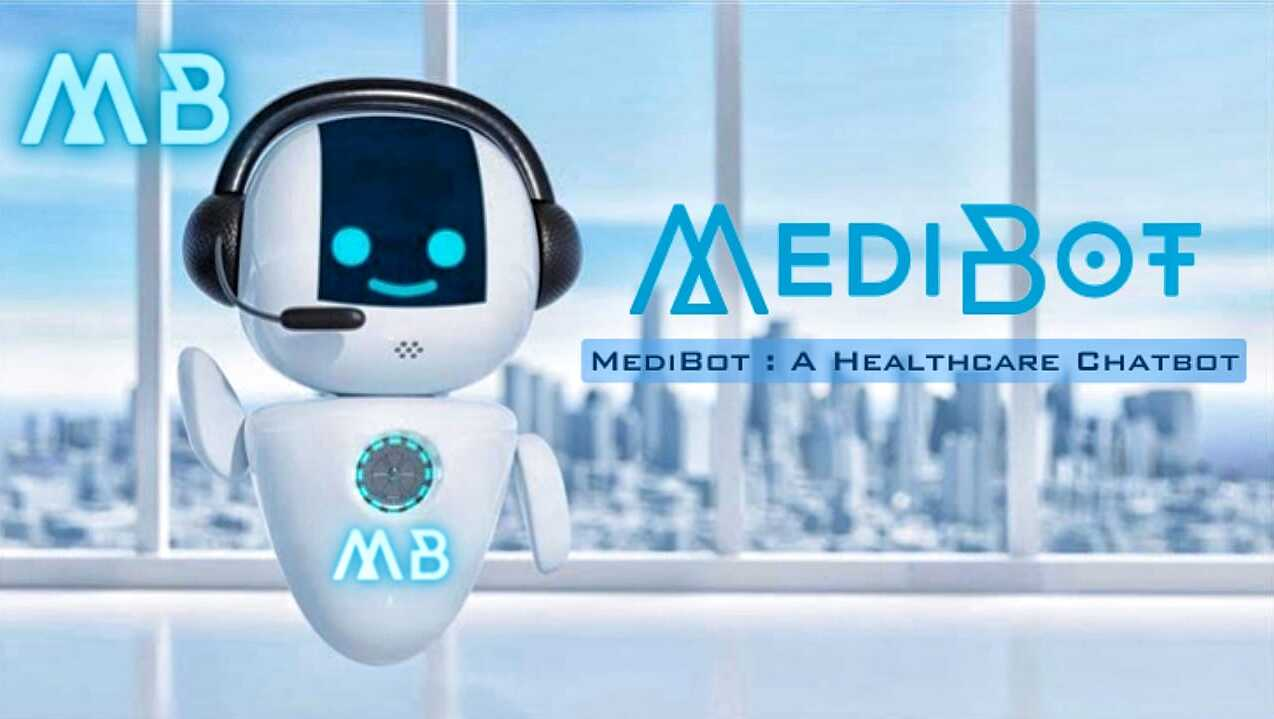

# **BUSINESS PROBLEM:**

The healthcare industry grapples with the task of delivering prompt and accurate medical information to individuals seeking assistance with their health concerns. Patients require reliable and trustworthy sources of information to comprehend their symptoms,potential diseases and receive appropriate medical guidance. However, navigating through the vast expanse of online healthcare information poses a challenge for individuals seeking accurate and reliable resources, given the sheer volume of information available online. Therefore arises the necessity for an innovative and intuitive healthcare chatbot, poised to empower users in comprehending their symptoms, making disease predictions, and delivering more valuable information about the disease. By leveraging advanced natural language processing and machine learning techniques, a healthcare chatbot named **"MEDIBOT"** was developed which uses the syptoms from the input user, predicts potential disease and retrieves relevant information from the trusted sources.

The dataset used for the prediction of disease was obtained from Kaggle. The link to the dataset is given below:

https://www.kaggle.com/datasets/sushil9/disease-and-their-symptoms

# **INSTALLING REQUIRED LIBRARIES:**

The command "!pip install" allows us to add new libraries in the python environment.

In [1]:
!pip install cosine_similarity
!pip install gTTS


# **IMPORTING THE LIBRARIES:**

The healthcare chatbot utilizes various libraries like pandas, sci-kit learn, spacy and gtts for its functionality. By importing these libraries we can reuse pre-existing code and also structure our code effectively.

In [2]:
import pandas as pd
import sklearn.feature_extraction.text
import sklearn.model_selection
import sklearn.svm
import sklearn.linear_model
import sklearn.metrics
import requests
import spacy
import textwrap
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from gtts import gTTS
from IPython.display import Audio

# **LOADING THE DATASET:**

The dataset is loaded using the pandas library. This can help us to analyze the data and also preprocess data containing information on diseases and symptoms.The cahtbot gain access to the whole dataset which enables it to make predictions accurately.

In [3]:
df = pd.read_csv("/content/dataset (2).csv")# Loading the dataset
df.head() #Displays the first five rows of the dataset

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**A new column named "sympyoms" is created by combining all the symptoms and then unnecessary columns are dropped.**

In [4]:
symptom_columns = [f"Symptom_{i}" for i in range(1,18)]
df = df.assign(symptoms = df[symptom_columns].apply(lambda x: ",".join(x.dropna()), axis = 1))
df.drop(symptom_columns, axis = 1, inplace = True)
df.head()

,Disease,symptoms
0,Fungal infection,"itching, skin_rash, nodal_skin_eruptions, disc..."
1,Fungal infection,"skin_rash, nodal_skin_eruptions, dischromic _..."
2,Fungal infection,"itching, nodal_skin_eruptions, dischromic _pat..."
3,Fungal infection,"itching, skin_rash, dischromic _patches"
4,Fungal infection,"itching, skin_rash, nodal_skin_eruptions"


**The distribution of the symptoms can be visualized using a bar plot. The barplot will help us to identify common and rare symptoms.**

From the bar plot it is clear that Fatigue and Vomitting are the most common symptoms.

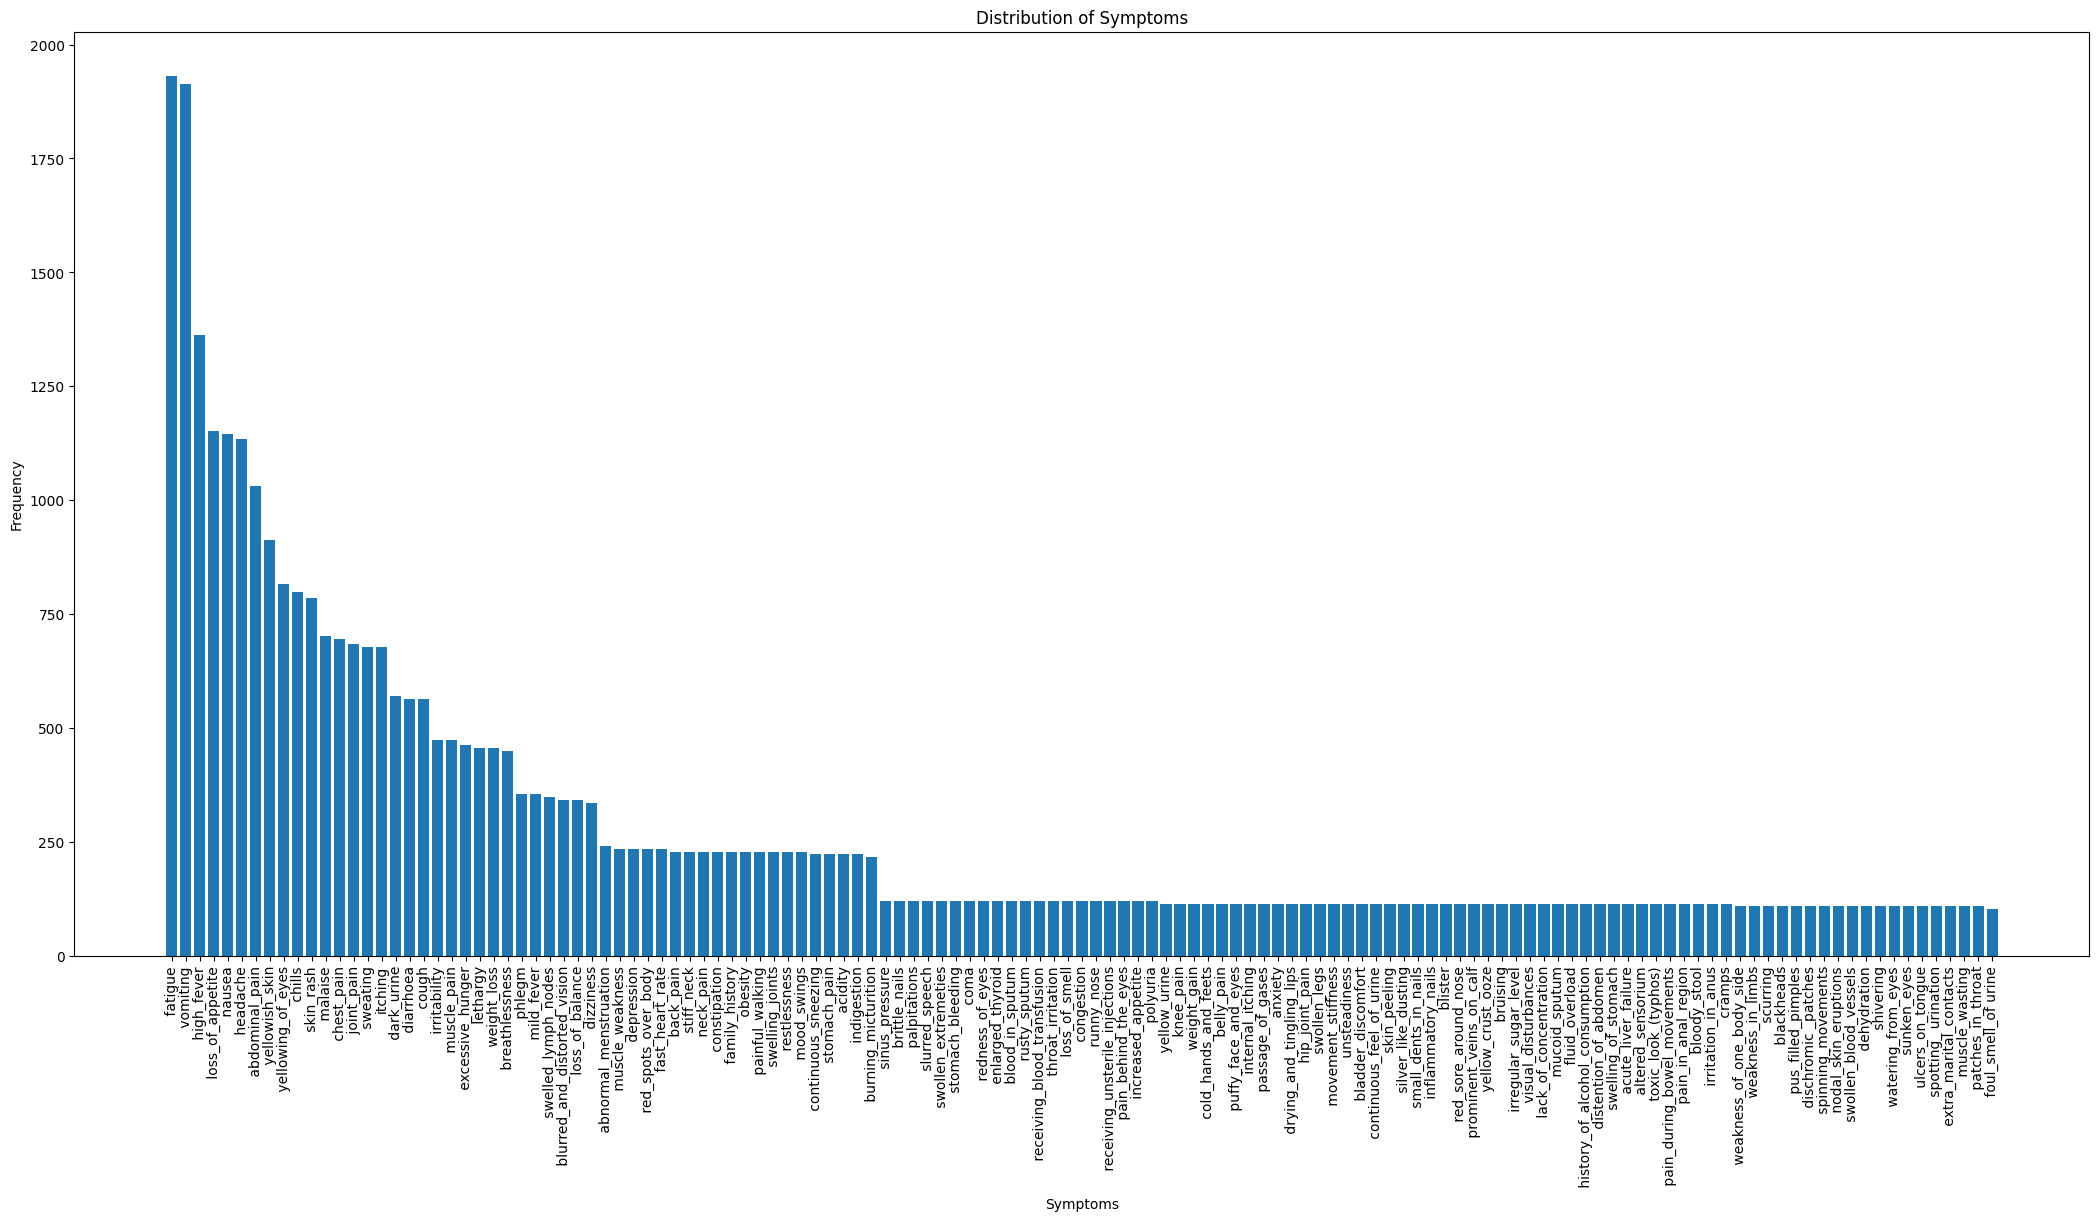

In [29]:
symptom_counts = df.symptoms.str.split(",", expand = True).stack().value_counts()
plt.figure(figsize = (26,12))
plt.bar(symptom_counts.index,symptom_counts.values)
plt.xlabel("Symptoms")
plt.ylabel("Frequency")
plt.title("Distribution of Symptoms")
plt.xticks(rotation = 90)
plt.show()


**To understand the structure and composition of the dataframe we use the info() function. It helps us to identify missing values,data types of each column and memory used.**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Disease   4920 non-null   object
 1   symptoms  4920 non-null   object
dtypes: object(2)
memory usage: 77.0+ KB


**The unique() function enables us to find the diverse range of health conditions addressed by the chatbot. This is important to make precise disease prediction and recommendation capabilities within the chatbot.**

In [7]:
df.Disease.unique()

array(['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis',
       'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes ',
       'Gastroenteritis', 'Bronchial Asthma', 'Hypertension ', 'Migraine',
       'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice',
       'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia',
       'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins',
       'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia',
       'Osteoarthristis', 'Arthritis',
       '(vertigo) Paroymsal  Positional Vertigo', 'Acne',
       'Urinary tract infection', 'Psoriasis', 'Impetigo'], dtype=object)

In [8]:
df["symptoms"] = df["symptoms"].apply(lambda x: x.lower())

**The tf-idf is used to transform textual data to a matrix of tf-idf features.**

In [9]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = "english")
X = tfidf.fit_transform(df["symptoms"])
y = df["Disease"]
X_train,X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size = 0.2)

In [10]:
import sklearn.svm
svm = sklearn.svm.SVC()
svm.fit(X_train,y_train)

SVC()

In [11]:
#Predicting the target with test set

y_predicted = svm.predict(X_test)

#Calculating the accuracy of the model:
svm_accuracy = sklearn.metrics.accuracy_score(y_test,y_predicted)
print ("The accuracy of the svm model is", svm_accuracy*100, "%")

The accuracy of the svm model is 100.0 %


#**TEXT PREPROCESSING AND SUMMARIZATION:**

Text pre-processing and summarization is essential while developing a healthcare chatbot as they eliminate noise and improve the data quality. Users obtain precise and accurate responses which improves their interaction with chatbot.

In [12]:
# The code loads a pretrained Natural Language Processing English Language model from the spaCy library.
nlp = spacy.load("en_core_web_sm")

In [13]:
def text_preprocessing_and_summarization(data):
  data = data.lower()# converting the data to lowercase
  data = data.replace("\n", " ")#line breaks are replaced with the spaces
  data = " ".join([token for token in data.split() if token not in STOP_WORDS])

  nlp = English()
  nlp.add_pipe("sentencizer")
  doc = nlp(data)
  sentences = [sent.text for sent in doc.sents]
  summary = " ".join(sentences[:5])

  return summary


# **NAMED ENTITY RECOGNITION:**

Named Entity Recognition helps us to identify and extract important entities such as disease, symptoms, etc. It enables the chatbot to understand the query of the user and respond accordingly.

In [14]:
def named_entity_recognition(text):
  doc = nlp(text)
  entities = []
  for entity in doc.ents:
    entities.append(entity.text)
  return entities

# **PREDICTION OF DISEASE:**

The predict_disease function performs the prediction of disease based on the symptoms provided by the user. It takes symptoms as the input and uses vectorized symptoms from tf-idf transformation. This is then passed to SVM model for disease prediction. The function returns the disease based on the symptopms.

In [15]:
def predict_disease(symptoms):
  symptoms_vectorized = tfidf.transform([symptoms])
  disease_prediction = svm.predict(symptoms_vectorized)
  return disease_prediction[0]

# **WEB SCRAPPING DETAILS ABOUT THE DISEASE:**

The function scrape_disease_details is responsible for scrapping details about diseases from the NHS Website. It takes the name of the disease as input and generates URL to access the corresponding page.

In [16]:
def scrape_disease_details(disease):
  url = f"https://www.nhs.uk/conditions/{disease}/"
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")
  page_content = soup.get_text(strip = True)
  paragraph = textwrap.fill(page_content, width = 80)
  return paragraph

# **TEXT-TO-SPEECH:**

The speak function uses gTTS library to convert the textual data to speech. By passing the text parameter and specifying the language the text will be converted and generates an audio file representing the conversion

In [17]:
def speak(text):
  tts = gTTS(text = text, lang = "en")
  tts.save("chatbot output.mp3")
  audio = Audio(filename="chatbot output.mp3" )
  display(audio)

# **BUILDING VIRTUAL ASSISTANT:**

The virtual assistant function is designed to handle user queries and provide response based on the input. It utilizes conditional statements to determine the type of query and generate the corresponding response. The speak function is also called within the virtual assistant function to convert the response into speech enhancing user experience.

In [18]:
def virtual_assistant(query):
  if query.lower()== "hello":
    response = "Hello! How can i assist you today?"
    speak(response)
    return (response)
  elif query.lower() =="thank you":
    response = "You're Welcome! if you have any more questions, feel free to ask."
    speak(response)
    return (response)
  else:
    user_input = input("Please enter your query(Enter disease or symptoms): ")
    if user_input.lower() == "disease":
      disease = input("Please enter the name of the disease you want to know about: ")
      scraped_details = scrape_disease_details(disease)
      response = f"The information related to the disease {disease} is displayed below."
      speak (response)
      return response
    elif user_input.lower() == "symptoms":
      symptoms = input("Please enter the symptoms you are experiencing")
      ner_entities = named_entity_recognition(symptoms)
      processed_input = " ".join([entity for entity in ner_entities if entity not in ["SYMPTOM", "DISEASE"]])
      predicted_disease = predict_disease(processed_input)
      scraped_details = scrape_disease_details(predicted_disease)
      print("Predicted Disease:", predicted_disease)
      print ("Scraped Details:")
      print (scraped_details)
      response = f"The most likely disease according to your symptom is {predicted_disease}"
      speak (response)
      return response
    else:
      response = "Invalid Input. Please Try Again"
      speak (response)
      return response


# **CHATBOT LOGIC AND INTERACTION:**

This block of code represents the Logic MediBot. The chatbot starts with a welcome message.
Then it enters a continous while loop that allows continous interaction with the user until the user decides to quit.
Within each iteration the user is prompted to enter a query which has 3 options: disease, symptoms or exit.
If the user input is exit the program breaks out of the loop, terminating the program.
If the user input is recognized as a virtual assistant query it retrieves the response from the virtual assistant function
and prints it.
If the user input is not recognized as a virtual assistan query the program checks the current state. If the state is start
and user inputs disease then it will prompt the user to enter disease name.If the state is start
and user inputs symptoms then it will prompt the user to enter symptoms. The virtual assistant responds accordingly.

In [22]:
print("Welcome to MediBot!")
speak ("Welcome to MediBot!")
state = "start"
while True:
  user_input = input("Please enter your query(Disease or Symptoms or type 'exit'): ")
  if user_input.lower() == "exit":
    print("Thank You for using MediBot. GoodBye!")
    speak("Thank You for using MediBot. GoodBye!")
    break
  if user_input.lower() in ["hello", "thank you"]:
    response = virtual_assistant(user_input)
    print("Virtual Assistant:", response)
    continue
  else:
    if state == "start":
      if "disease" in user_input:
        response  = "Please enter the name of the disease you want to know about: "
        state = "disease"
      elif "symptoms" in user_input:
        response  = "Please enter the symptoms you are experiencing: "
        state = "symptoms"
      else:
        response = "I'm sorry, I couldn't understand your query. Could you please rephrase?"
    elif state =="disease":
      scraped_details = scrape_disease_details(user_input)
      print (scraped_details)
      response = f"The information related to the disease {user_input} is displayed below."
      state = "start"
    elif state == "symptoms":
      ner_entities = named_entity_recognition(user_input)
      processed_input = " ".join([entity for entity in ner_entities if entity not in ["SYMPTOM", "DISEASE"]])
      predicted_disease = predict_disease(processed_input)
      scraped_details = scrape_disease_details(predicted_disease)
      print("Predicted Disease:", predicted_disease)
      print ("Scraped Details:")
      print (scraped_details)
      response = f"The most likely disease according to your symptom is {predicted_disease}"
      state = "start"
      print("Virtual Assistant:", response)
    speak(response)
    print("Virtual Assistant:", response)



Welcome to MediBot!


Please enter your query(Disease or Symptoms or type 'exit'): disease


Virtual Assistant: Please enter the name of the disease you want to know about: 
Please enter your query(Disease or Symptoms or type 'exit'): Diabetes
Diabetes  - NHSSkip to main contentSearch the NHS websiteSearchHealth A-ZNHS
servicesLive WellMental healthCare and supportPregnancyHomeNHS
servicesBrowseMoreHomeHealth A to ZBack toHealth A to ZDiabetesDiabetes is a
condition that causes a person's blood sugar level to become too high.There
are 2 main types of diabetes:type 1 diabetes– a lifelong condition where the
body's immune system attacks and destroys the cells that produce insulintype 2
diabetes– where the body does not produce enough insulin, or the body's cells do
not react to insulin properlyType 2 diabetes is far more common than type 1.
In the UK, over 90% of all adults with diabetes have type 2.High blood sugar
that develops during pregnancy is known asgestational diabetes. It usually goes
away after giving birth.Non-diabetic hyperglycaemia (pre-diabetes)Many people
have bl

Virtual Assistant: The information related to the disease Diabetes is displayed below.
Please enter your query(Disease or Symptoms or type 'exit'): symptoms


Virtual Assistant: Please enter the symptoms you are experiencing: 
Please enter your query(Disease or Symptoms or type 'exit'): i'm having vomitting and diarrhoea
Predicted Disease: Gastroenteritis
Scraped Details:
Diarrhoea and vomiting  - NHSSkip to main contentSearch the NHS
websiteSearchHealth A-ZNHS servicesLive WellMental healthCare and
supportPregnancyHomeNHS servicesBrowseMoreHomeHealth A to ZBack toHealth A to
ZDiarrhoea and vomitingDiarrhoea and vomiting are common in adults, children and
babies. They're often caused by a stomach bug and should stop in a few days.The
advice is the same if you have diarrhoea and vomiting together or separately.How
to treat diarrhoea and vomiting yourselfYou can usually treat yourself or your
child at home. The most important thing is to have lots of fluids to avoid
dehydration.Dostay at home and get plenty of restdrink lots of fluids, such as
water or squash – take small sips if you feel sickcarry on breast or bottle
feeding your baby – if th

Virtual Assistant: The most likely disease according to your symptom is Gastroenteritis
Please enter your query(Disease or Symptoms or type 'exit'): exit
Thank You for using MediBot. GoodBye!


**# PERFORMING TEXT PREPROCESSING AND SUMMARIZATION ON THE SCRAPED DETAILS**

The code performs text preprocessing and summarization on the scraped details of the disease, providing a concise and summarized representation of the details. The summarized details are printed using print() function and spoken using speak() function.

In [25]:
summarized_details = text_preprocessing_and_summarization(scraped_details)
print("Predicted Disease: ", predicted_disease)
print("Summarized Details:")
print(summarized_details)
speak(summarized_details)


Predicted Disease:  Gastroenteritis
Summarized Details:
diarrhoea vomiting - nhsskip main contentsearch nhs websitesearchhealth a-znhs serviceslive wellmental healthcare supportpregnancyhomenhs servicesbrowsemorehomehealth zback tohealth zdiarrhoea vomitingdiarrhoea vomiting common adults, children babies. they're caused stomach bug stop days.the advice diarrhoea vomiting separately.how treat diarrhoea vomiting yourselfyou usually treat child home. important thing lots fluids avoid dehydration.dostay home plenty restdrink lots fluids, water squash – small sips feel sickcarry breast bottle feeding baby – they're sick, try giving small feeds usualgive babies formula solid foods small sips water feedseat feel able – need eat avoid specific foodstakeparacetamolif you're discomfort – check leaflet giving childdon’tdo fruit juice fizzy drinks – diarrhoea worsedo baby formula weaker – use usual strengthdo children 12 medicine stop diarrhoeado aspirin children 16help improve websitecan answer 

**# PERFORMING NAMED ENTITY RECOGNITION ON THE SCRAPED DETAILS**

The function performs named entity recognition on the scraped details, extracting relevant entities from the corresponding webpage. These entities are printed and spoken using print() and speak() function.

In [24]:
ner_entities = named_entity_recognition(scraped_details)
ner_text = " ".join(ner_entities)
print("Named Entities:")
for entity in ner_entities:
  print(entity)
speak(ner_text)


Named Entities:
NHS
WellMental
a few days
Dostay
12
under 16Help
5
1
2
at least 2 days
washclean
2 weeks
over 5 years
a few
hours
under 12Find
111
12
under 5
years
5 years
more than 7 days
GP
GP
GP
GP
GP
Call 999
A&E
daily
07 December
07 December

2023Support
ZLive WellMental
NHS
NHSHealthcare
NHS
Crown


# **DISCUSSION:**

The healthcare chatbot utilizes machine learning algorithms, nlp techniques and webscrapping to provide personalized assisstance to users. It takes user input and predicts disease based on the symptoms. The chatbot also provides information on the predicted disease from a reputable source. To enhance the user experience, the chatbot also uses features like text summarization, named entity recognition and text to speech. The main strengths of the chatbot include:
1. The chatbot uses machine learning algorithms to predict diseases which will the improving the accuracy of prediction compared to online searches.
2. The chatbot allows users to interact with it anytime and anywhere,providing access to healthcare information.
3. The chatbot tailors its responses based on the user queries, ensuring relevant and specific information.


# **LIMITATIONS:**

While the chatbot demonstrates promising capabilities, it is important to acknowledge its limitations also. The limitations encompass a range of challenges. A few of them are explained below:
1. Data: The Accuracy of the disease prediction depends on the quality, completeness and comprehensiveness of the data used to train the machine learning model. if the dataset is limited in scope or contains incomplete information this will affect the chatbot's ability to produce accurate predictions.
2. Complexity of diagnosis: Certain diseases have similar Symptoms, leading to potential misdiagnosis.
3. Language: The chatbot supports only English inputs, which limits its accesibility to others who speaks other languages.



# **CONCLUSION:**

**"MEDIBOT"** will emerge as a powerful tool for empowering individuals to gain deeper insights into their symptoms, potential diseases and appropriate healthcare measures. However, further improvements are required to eliminate false positive and false negatives rates.Through continous refinement and integration of features like scheduling a doctor appointment, finding nearest medical shops and supporting the user input in multi- language user inputs , it holds the potential to revolutionize the healthcare landscape by providing personalized and reliable medical guidance to a diverse range of users. MEDIBOT aspires to bridge the gap betweeen patients and healthcare professionals with its user friendly interface and design. This empowers individuals to take a proactive role in manging their health and making informed decisions about their wellbeing.

# **REFERENCES:**

1. NHS Choices (2019). Health A-Z. [online] NHS. Available at: https://www.nhs.uk/conditions/.

2. Safi, Z., Abd-Alrazaq, A., Khalifa, M. and Househ, M. (2020). Technical Aspects of Developing Chatbots for Medical Applications: Scoping Review. Journal of Medical Internet Research, 22(12), p.e19127. doi:https://doi.org/10.2196/19127.

3. Chow, J. and Xu, L. (2021). Chatbot for Healthcare and Oncology Applications Using Artificial Intelligence and Machine Learning (Preprint). JMIR Cancer, 7(4). doi:https://doi.org/10.2196/27850.

4. Aadithyan, S., Sreelakshmi, U., Alias, H. and Rose, N. (2021). HEALTHCARE CHATBOT. [online] 9, p.65. Available at: https://ijcrt.org/papers/IJCRTH020011.pdf.

5. Chang, I-Chiu., Shih, Y.-S. and Kuo, K.-M. (2022). Why would you use medical chatbots? interview and survey. International Journal of Medical Informatics, 165, p.104827. doi:https://doi.org/10.1016/j.ijmedinf.2022.104827.

6. Athota, L., Shukla, V.K., Pandey, N. and Rana, A. (2020). Chatbot for Healthcare System Using Artificial Intelligence. [online] IEEE Xplore. doi:https://doi.org/10.1109/ICRITO48877.2020.9197833.


# **ASSESSMENT SUBMISSION FORM:**

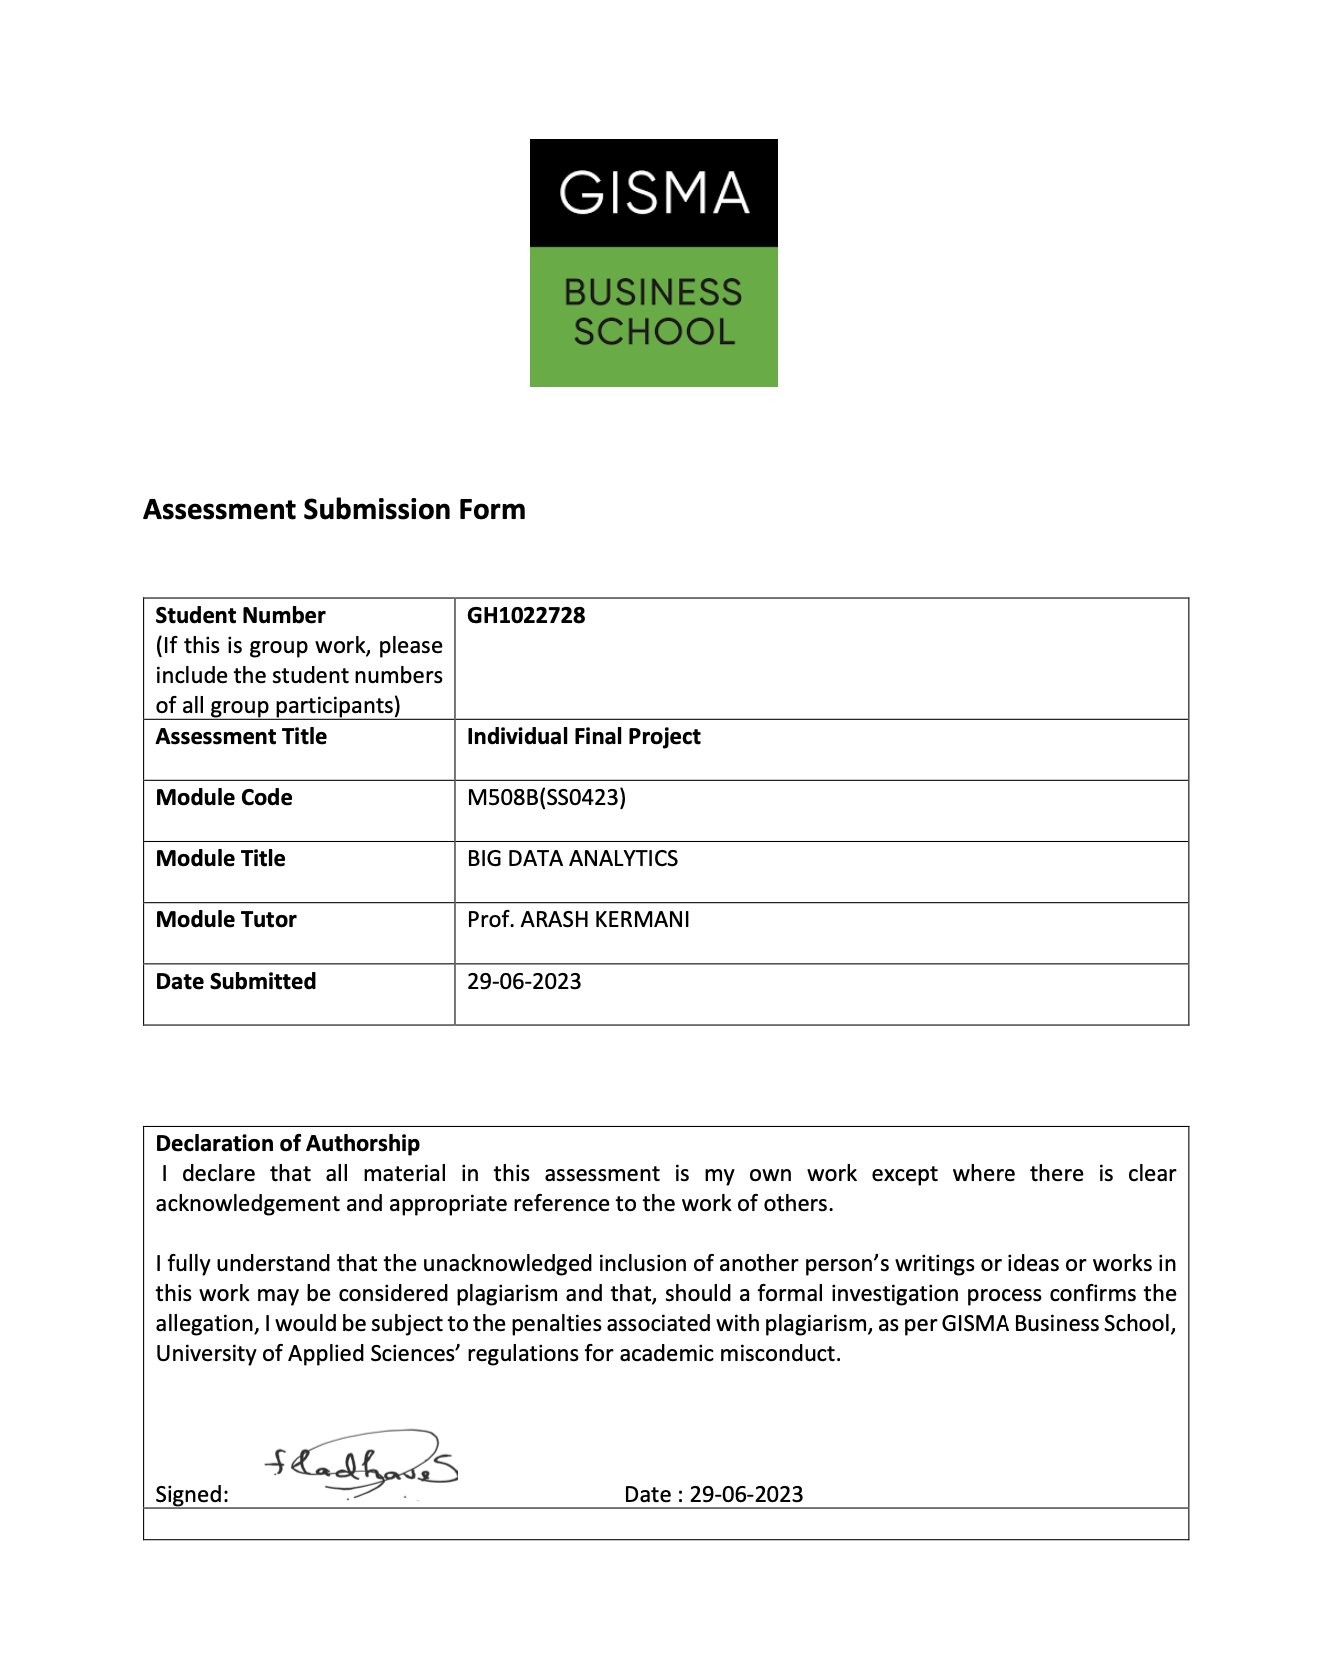

In [30]:
!pip install nbconvert

In [35]:
!jupyter nbconvert --to html MEDIBOT_A_HEALTHCARE_CHATBOT.ipynb

[NbConvertApp] Converting notebook MEDIBOT_A_HEALTHCARE_CHATBOT.ipynb to html
[NbConvertApp] Writing 3454828 bytes to MEDIBOT_A_HEALTHCARE_CHATBOT.html
